# Терешенков БВТ2203. Лаб. работа №3. GAN для генерации на датасете MNIST

In [1]:
import torchvision.transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.fc1 = nn.Linear(784, 512)
#         self.fc2 = nn.Linear(512, 256)
#         self.fc3 = nn.Linear(256, 1)
#         self.activation = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()
#     def forward(self, x):
#         x = self.activation(self.fc1(x))
#         x = self.activation(self.fc2(x))
#         x = self.fc3(x)
#         return self.sigmoid(x)

# class Generator(nn.Module):
#     def __init__(self, latent_space):
#         super(Generator, self).__init__()
#         self.fc1 = nn.Linear(latent_space, 1024)
#         self.fc2 = nn.Linear(1024, 2048)
#         self.fc3 = nn.Linear(2048, 784)
#         self.activation = nn.ReLU()
#         self.tanh = nn.Tanh()

#     def forward(self, x):
#         x = self.activation(self.fc1(x))
#         x = self.activation(self.fc2(x))
#         x = self.fc3(x)
#         x = x.view(-1, 1, 28, 28)
#         return self.tanh(x)


In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self, latent_space):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_space, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.model(x)
        return x.view(-1, 1, 28, 28)

In [5]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

In [6]:
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Нормализация в [-1, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
discrimnator = Discriminator().to(device)
generator = Generator(128).to(device)

generator.apply(init_weights)
discrimnator.apply(init_weights)

d_optim = torch.optim.Adam(discrimnator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optim = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

d_crit = nn.BCELoss()
g_crit = nn.BCELoss()

In [8]:
def plot_train_results(images, epoch):

    plt.figure(figsize=(7, 5))

    img = images[0].view(-1, 1, 28, 28)
    plt.subplot(1, 3, 1)
    plt.imshow(img.cpu().detach().numpy().squeeze(), cmap="gray")
    plt.title(f'Image 1 Epoch {epoch}')
    plt.axis('off')

    img = images[1].view(-1, 1, 28, 28).cpu()
    plt.subplot(1, 3, 2)
    plt.imshow(img.cpu().detach().numpy().squeeze(), "gray")
    plt.title(f'Image 2 Epoch {epoch}')
    plt.axis('off')

    img = images[2].view(-1, 1, 28, 28).cpu()
    plt.subplot(1, 3, 3)
    plt.imshow(img.cpu().detach().numpy().squeeze(), "gray")
    plt.title(f'Image 3 Epoch {epoch}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [9]:
def train_models(models, train_loader, optimizers, criterions, num_epochs=50, latent_size=128):
    models["discriminator"].train()
    models["generator"].train()

    g_losses = []
    d_losses = []
    
    for epoch in range(num_epochs):
        g_epoch_loss = 0.0
        d_epoch_loss = 0.0
        last_images = None

        for batch_idx, (data, _) in enumerate(train_loader):
            current_batch_size = data.size(0)
            data = data.view(data.size(0), -1).to(device)  # [batch_size, 784]

            #Discriminator trainnig
            optimizers["discriminator"].zero_grad()
            real_preds = models["discriminator"](data)
            real_targets = torch.ones(current_batch_size, 1, device=device)
            real_loss = criterions["discriminator"](real_preds, real_targets)

            latent = torch.randn(current_batch_size, latent_size, device=device)
            fake_images = models["generator"](latent)
            fake_images = fake_images.view(fake_images.size(0), -1)
            fake_targets = torch.zeros(current_batch_size, 1, device=device)
            fake_preds = models["discriminator"](fake_images)
            fake_loss = criterions["discriminator"](fake_preds, fake_targets)

            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizers["discriminator"].step()
            d_epoch_loss += loss_d.item()
            
            #train generator
            optimizers["generator"].zero_grad()

            latent = torch.randn(current_batch_size, latent_size, device=device)
            fake_images = models["generator"](latent)
            fake_images = fake_images.view(fake_images.size(0), -1)
            last_images = fake_images
            
            preds = models["discriminator"](fake_images)
            targets = torch.ones(current_batch_size, 1, device=device)
            loss_g = criterions["generator"](preds, targets)
            
            loss_g.backward()
            optimizers["generator"].step()
            g_epoch_loss += loss_g.item()

        if(epoch % 10 == 0 and epoch != 0):
            plot_train_results(last_images[0:3, :], epoch)

        g_avg = g_epoch_loss / len(train_loader)
        d_avg = d_epoch_loss / len(train_loader)
        g_losses.append(g_avg)
        d_losses.append(d_avg)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: G = {g_avg:.6f}, D = {d_avg}')
    
    return g_losses, d_losses

In [10]:
models = {
    "discriminator":discrimnator,
    "generator":generator
}

criterions = {
    "discriminator":d_crit,
    "generator":g_crit
}

optimizers = {
    "discriminator":d_optim,
    "generator":g_optim
}

Epoch [1/100], Average Loss: G = 1.212663, D = 0.9763771347812752
Epoch [2/100], Average Loss: G = 0.867498, D = 1.2467090775971728
Epoch [3/100], Average Loss: G = 0.809100, D = 1.2973715384631777
Epoch [4/100], Average Loss: G = 0.761899, D = 1.3369278822626387
Epoch [5/100], Average Loss: G = 0.727161, D = 1.363946877817101
Epoch [6/100], Average Loss: G = 0.719409, D = 1.372043792754094
Epoch [7/100], Average Loss: G = 0.714586, D = 1.376245422912305
Epoch [8/100], Average Loss: G = 0.709284, D = 1.3796022094643192
Epoch [9/100], Average Loss: G = 0.706118, D = 1.382380300366294
Epoch [10/100], Average Loss: G = 0.705112, D = 1.383121959817435


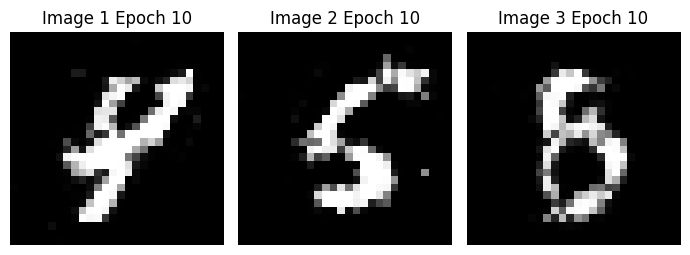

Epoch [11/100], Average Loss: G = 0.704256, D = 1.3840706349690077
Epoch [12/100], Average Loss: G = 0.702135, D = 1.385087211503149
Epoch [13/100], Average Loss: G = 0.701232, D = 1.3849202775751859
Epoch [14/100], Average Loss: G = 0.700727, D = 1.3855575785708072
Epoch [15/100], Average Loss: G = 0.699543, D = 1.385213974442309
Epoch [16/100], Average Loss: G = 0.699388, D = 1.3859523444541737
Epoch [17/100], Average Loss: G = 0.698485, D = 1.3857815380035432
Epoch [18/100], Average Loss: G = 0.697210, D = 1.3860403204015068
Epoch [19/100], Average Loss: G = 0.697533, D = 1.3861437527609786
Epoch [20/100], Average Loss: G = 0.697167, D = 1.385928011652249


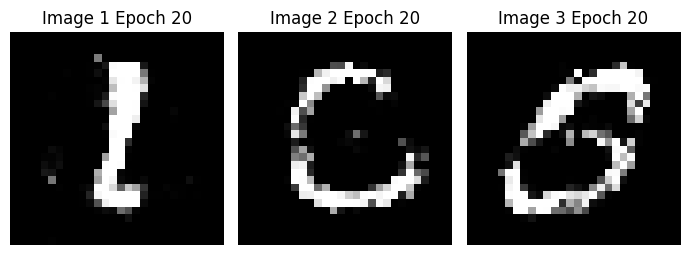

Epoch [21/100], Average Loss: G = 0.697604, D = 1.3862412484215776
Epoch [22/100], Average Loss: G = 0.695957, D = 1.3862977368491036
Epoch [23/100], Average Loss: G = 0.696176, D = 1.3859856057522901
Epoch [24/100], Average Loss: G = 0.695729, D = 1.3865360631617403
Epoch [25/100], Average Loss: G = 0.696558, D = 1.3859011260177028
Epoch [26/100], Average Loss: G = 0.696224, D = 1.38585236166586
Epoch [27/100], Average Loss: G = 0.695803, D = 1.3859994171270684
Epoch [28/100], Average Loss: G = 0.696274, D = 1.385902401862114
Epoch [29/100], Average Loss: G = 0.696661, D = 1.3861730793900073
Epoch [30/100], Average Loss: G = 0.696338, D = 1.3857640948122754


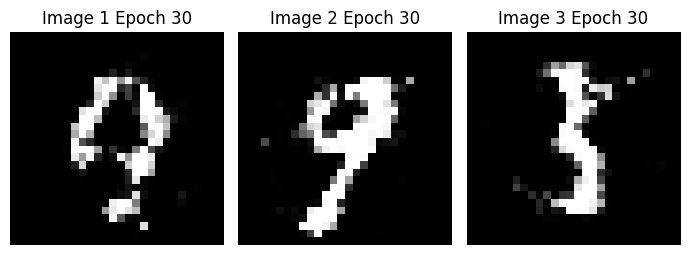

Epoch [31/100], Average Loss: G = 0.696189, D = 1.3859244416009133
Epoch [32/100], Average Loss: G = 0.696622, D = 1.3858157214579552
Epoch [33/100], Average Loss: G = 0.696117, D = 1.3857070502441828
Epoch [34/100], Average Loss: G = 0.697631, D = 1.385512159450222
Epoch [35/100], Average Loss: G = 0.696100, D = 1.3856224167321536
Epoch [36/100], Average Loss: G = 0.697498, D = 1.3852639948127112
Epoch [37/100], Average Loss: G = 0.696757, D = 1.3856809345135557
Epoch [38/100], Average Loss: G = 0.696771, D = 1.3855878288811967
Epoch [39/100], Average Loss: G = 0.697071, D = 1.385549057775469
Epoch [40/100], Average Loss: G = 0.696573, D = 1.3858461298668054


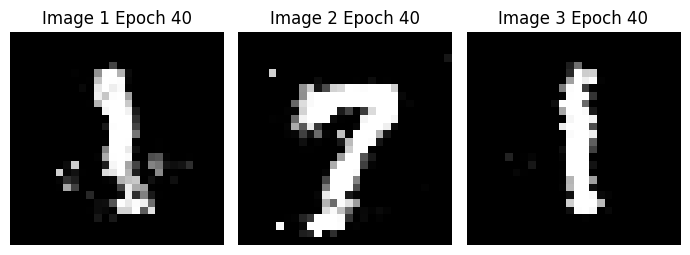

Epoch [41/100], Average Loss: G = 0.695896, D = 1.3855409943727033
Epoch [42/100], Average Loss: G = 0.696969, D = 1.3861703252487345
Epoch [43/100], Average Loss: G = 0.696339, D = 1.386040937290517
Epoch [44/100], Average Loss: G = 0.696855, D = 1.3857435113839758
Epoch [45/100], Average Loss: G = 0.696888, D = 1.3854855717118106
Epoch [46/100], Average Loss: G = 0.696450, D = 1.3855743748801095
Epoch [47/100], Average Loss: G = 0.696273, D = 1.3859514353880242
Epoch [48/100], Average Loss: G = 0.696843, D = 1.3852573077815937
Epoch [49/100], Average Loss: G = 0.697185, D = 1.385472427807383
Epoch [50/100], Average Loss: G = 0.697423, D = 1.3850601802248437


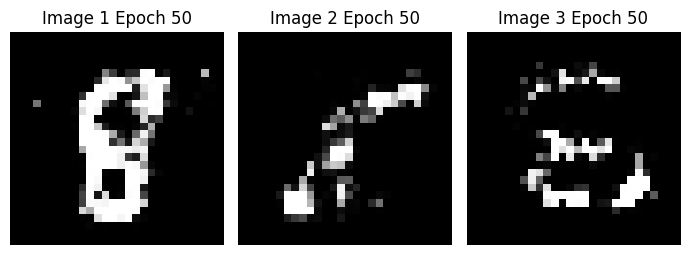

Epoch [51/100], Average Loss: G = 0.698227, D = 1.3848356889255011
Epoch [52/100], Average Loss: G = 0.698390, D = 1.3843269038047872
Epoch [53/100], Average Loss: G = 0.698296, D = 1.3842319757191104
Epoch [54/100], Average Loss: G = 0.698096, D = 1.3842098265568585
Epoch [55/100], Average Loss: G = 0.699310, D = 1.3843506167946593
Epoch [56/100], Average Loss: G = 0.699570, D = 1.3839114650226096
Epoch [57/100], Average Loss: G = 0.699679, D = 1.383889982949442
Epoch [58/100], Average Loss: G = 0.700537, D = 1.3828357674165574
Epoch [59/100], Average Loss: G = 0.699152, D = 1.3842294742303616
Epoch [60/100], Average Loss: G = 0.700257, D = 1.3839091114652182


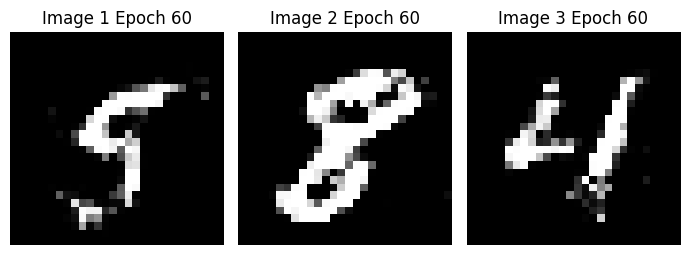

Epoch [61/100], Average Loss: G = 0.700738, D = 1.382978065054554
Epoch [62/100], Average Loss: G = 0.700119, D = 1.3825876364575775
Epoch [63/100], Average Loss: G = 0.702933, D = 1.3825248301918827
Epoch [64/100], Average Loss: G = 0.702666, D = 1.382008485956741
Epoch [65/100], Average Loss: G = 0.702977, D = 1.381376844479331
Epoch [66/100], Average Loss: G = 0.702408, D = 1.3813303031646875
Epoch [67/100], Average Loss: G = 0.703953, D = 1.380413093800738
Epoch [68/100], Average Loss: G = 0.704621, D = 1.3797374573597776
Epoch [69/100], Average Loss: G = 0.705515, D = 1.3803292795030802
Epoch [70/100], Average Loss: G = 0.705092, D = 1.3801468741665008


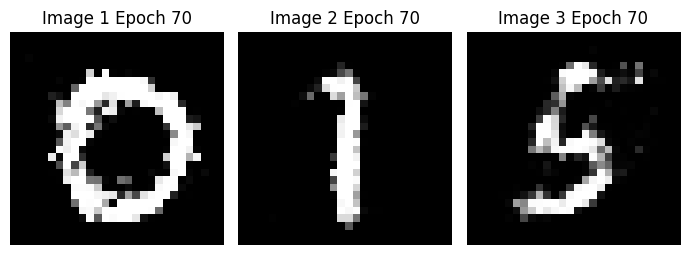

Epoch [71/100], Average Loss: G = 0.705627, D = 1.3798095971536535
Epoch [72/100], Average Loss: G = 0.706479, D = 1.3786577710718997
Epoch [73/100], Average Loss: G = 0.706602, D = 1.378974683630441
Epoch [74/100], Average Loss: G = 0.708787, D = 1.3773663697212235
Epoch [75/100], Average Loss: G = 0.708689, D = 1.378716803944187
Epoch [76/100], Average Loss: G = 0.708089, D = 1.377706281793143
Epoch [77/100], Average Loss: G = 0.709891, D = 1.3758822355443225
Epoch [78/100], Average Loss: G = 0.710952, D = 1.3768844112658551
Epoch [79/100], Average Loss: G = 0.710685, D = 1.3769345269528532
Epoch [80/100], Average Loss: G = 0.709584, D = 1.3772778437335862


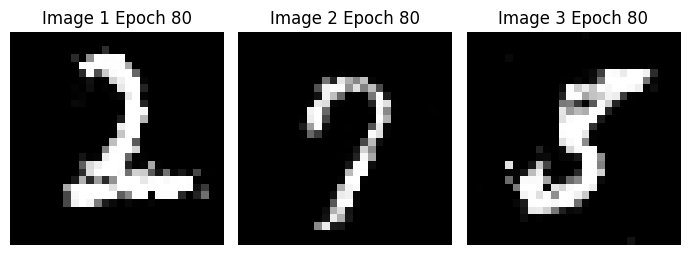

Epoch [81/100], Average Loss: G = 0.711282, D = 1.3763983290332722
Epoch [82/100], Average Loss: G = 0.710556, D = 1.3745507614444823
Epoch [83/100], Average Loss: G = 0.711993, D = 1.3749201224048508
Epoch [84/100], Average Loss: G = 0.714938, D = 1.3748348150680314
Epoch [85/100], Average Loss: G = 0.716899, D = 1.372546106640464
Epoch [86/100], Average Loss: G = 0.715467, D = 1.372480877808162
Epoch [87/100], Average Loss: G = 0.717084, D = 1.3725394077900885
Epoch [88/100], Average Loss: G = 0.719779, D = 1.371347981221132
Epoch [89/100], Average Loss: G = 0.718982, D = 1.3706977672414231
Epoch [90/100], Average Loss: G = 0.721365, D = 1.3689282249285977


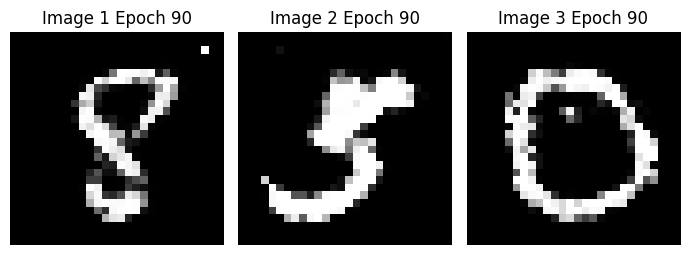

Epoch [91/100], Average Loss: G = 0.722308, D = 1.3688131411955047
Epoch [92/100], Average Loss: G = 0.724532, D = 1.3680444916428278
Epoch [93/100], Average Loss: G = 0.727141, D = 1.36614594784881
Epoch [94/100], Average Loss: G = 0.725528, D = 1.3657613380123048
Epoch [95/100], Average Loss: G = 0.729495, D = 1.3646255164766616
Epoch [96/100], Average Loss: G = 0.730260, D = 1.3645912642672118
Epoch [97/100], Average Loss: G = 0.732983, D = 1.3619713731157754
Epoch [98/100], Average Loss: G = 0.736490, D = 1.36075885476334
Epoch [99/100], Average Loss: G = 0.735873, D = 1.3613528716030405
Epoch [100/100], Average Loss: G = 0.736504, D = 1.359979170217697


In [11]:
g_losses, d_losses = train_models(models, train_loader, optimizers, criterions, num_epochs=100)

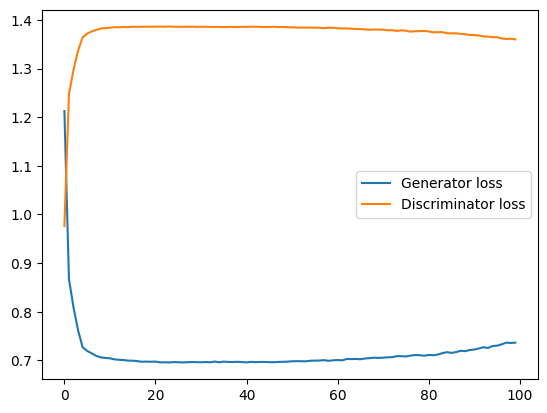

In [13]:
plt.plot(g_losses, label="Generator loss")
plt.plot(d_losses, label="Discriminator loss")
plt.legend()
plt.show()

In [21]:
def plot_validation_results(images, images_count):
    plt.figure(figsize=(7, 5))
    for i in range(images.shape[0]):
        img = images[i].view(-1, 1, 28, 28)
        plt.subplot(1, images_count, i + 1)
        plt.imshow(img.cpu().detach().numpy().squeeze(), cmap="gray")
        plt.title(f'Image {i + 1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

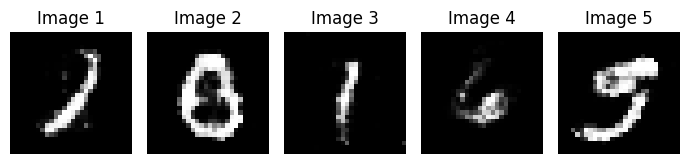

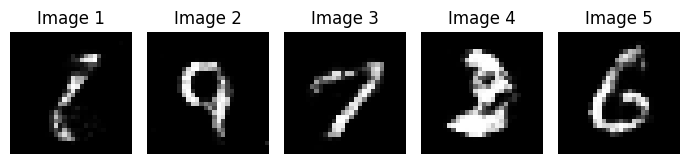

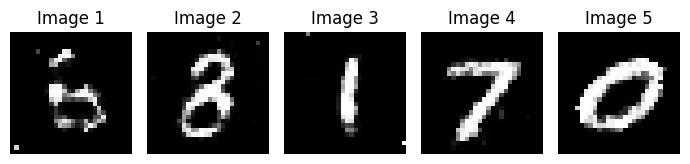

In [28]:
for i in range(3):
    latent_vector = torch.randn(5, 128, device=device)
    results = generator(latent_vector)
    plot_validation_results(results, 5)